In [ ]:
!pip install transformers
!pip install emoji
!pip install contractions
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu12

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import torch
import numpy as np
dir = '/content/drive/My Drive/1513-project/'

#Preprocess Dataset Used For Fine-tuning

In [ ]:
# Preprocess the data to be used for fine-tuning
import pandas as pd
headers = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = pd.read_csv(dir + 'labeled_tweets.csv', encoding='ISO-8859-1', header=None, names=headers)
print(df.head())

   target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  


In [ ]:
import pandas as pd
headers = ['tweet', 'language']
df = pd.read_csv(dir + 'us_election-edit.csv', encoding='ISO-8859-1', usecols=headers, lineterminator='\n')
df = df[df['language'] == 'en']
df = df.rename(columns={'tweet': 'text'})
print(df.head())

                                                text language
0  Hi if you want Americans to infuriate you in t...       en
1  @armstrongcbc No surprise. It's going to be a ...       en
2  I canât wait till after the US election so I...       en
3  America as a foreign country, by foreign corre...       en
4  Wow. I guess if you want actual journalism and...       en


In [ ]:
import emoji
import re
import contractions
def preprocess_data_cleaning(df):
  # First we lower case the data
  df['text_cleaned'] = df['text'].apply(lambda x: x.lower())
  df['text_cleaned'] = df['text_cleaned'].str.replace(r'(http\S+|www\.\S+)', '', regex=True) # Remove url
  df['text_cleaned'] = df['text_cleaned'].str.replace(r'<.*?>', '', regex=True) # remove html tags
  df['text_cleaned'] = df['text_cleaned'].apply(lambda x: emoji.demojize(x)) # remove emojis
  df['text_cleaned'] = df['text_cleaned'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True) # remove special characters
  df['text_cleaned'] = df['text_cleaned'].apply(lambda x: contractions.fix(x)) # Fix contractions

  return df

def rename_label(df):
  label_map = {0:0, 2:1, 4:2}
  df['target'] = df['target'].map(label_map)
  df = df.rename(columns={'target': 'label'})

  return df

In [ ]:
import pandas as pd
# df = preprocess_data_cleaning(df)
# df = rename_label(df)
# print(df.head())
df = preprocess_data_cleaning(df)

print(df.head())

                                                text language  \
0  Hi if you want Americans to infuriate you in t...       en   
1  @armstrongcbc No surprise. It's going to be a ...       en   
2  I canât wait till after the US election so I...       en   
3  America as a foreign country, by foreign corre...       en   
4  Wow. I guess if you want actual journalism and...       en   

                                        text_cleaned  
0  hi if you want americans to infuriate you in t...  
1  armstrongcbc no surprise its going to be a vol...  
2  i cannot wait till after the us election so i ...  
3  america as a foreign country by foreign corres...  
4  wow i guess if you want actual journalism and ...  


# Pseudo Label and Tokenize Dataset

In [ ]:
from datasets import Dataset

# Load the pd frame into dataset to allow for batch processing
dataset = Dataset.from_pandas(df)
# dataset = dataset.remove_columns(['ids', 'date', 'flag', 'user', 'text'])
dataset = dataset.remove_columns(['text', 'language'])
print(dataset[0:5])

{'text_cleaned': ['hi if you want americans to infuriate you in the comments not realise the whole world does not vote in the us election and not know that ireland is not in britain this is the thread for you', 'armstrongcbc no surprise its going to be a volatile few weeks in the market what with the uselection and a lot more earnings results to come', 'i cannot wait till after the us election so i can make fun of the trump supporters and remind trump every day that he is a loser', 'america as a foreign country by foreign correspondents covering the us election  ', 'wow i guess if you want actual journalism and real coverage of the us election going to have to start watching skynewsaust whoever says the media in the us is not biased is just trying to be blind to the facts at this point   '], '__index_level_0__': [0, 1, 2, 3, 4]}


In [ ]:
from textblob import TextBlob

def get_pseudo_label(data):
    # Compute sentiment polarity to use as label
    polarity = TextBlob(data['text_cleaned']).sentiment.polarity
    # Define thresholds to assign a label:
    # For instance, label 2 for positive, 0 for negative, and 1 for neutral
    if polarity > 0.1:
        label = 2
    elif polarity < -0.1:
        label = 0
    else:
        label = 1
    return {"label": label}

# Apply the function to add a new column with pseudo-labels
dataset = dataset.map(get_pseudo_label)
print(dataset[0:5])

Map:   0%|          | 0/124586 [00:00<?, ? examples/s]

{'text_cleaned': ['hi if you want americans to infuriate you in the comments not realise the whole world does not vote in the us election and not know that ireland is not in britain this is the thread for you', 'armstrongcbc no surprise its going to be a volatile few weeks in the market what with the uselection and a lot more earnings results to come', 'i cannot wait till after the us election so i can make fun of the trump supporters and remind trump every day that he is a loser', 'america as a foreign country by foreign correspondents covering the us election  ', 'wow i guess if you want actual journalism and real coverage of the us election going to have to start watching skynewsaust whoever says the media in the us is not biased is just trying to be blind to the facts at this point   '], '__index_level_0__': [0, 1, 2, 3, 4], 'label': [2, 2, 2, 0, 1]}


In [ ]:
from transformers import AutoTokenizer

# Load the BERTweet tokenizer
tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base', use_fast=False)

# Function to tokenize the text in batches
def tokenize(text_batch, tokenizer):
  return tokenizer(
    text_batch['text_cleaned'],
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors="pt"
  )

In [ ]:
# Tokenize the cleaned text data in batches
tokenized_dataset = dataset.map(lambda x: tokenize(x, tokenizer), batched=True)
tokenized_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
print(tokenized_dataset[0])

Map:   0%|          | 0/124586 [00:00<?, ? examples/s]

{'label': tensor(2), 'input_ids': tensor([    0,   860,    65,    14,    96, 29849,     9, 53962,   760,    14,
           16,     6,  2532,    46,  4614,     6,   434,   220,   158,    46,
          759,    16,     6,   148,  1843,    13,    46,    68,    25, 35183,
           17,    46,    16, 50867,    33,    17,     6,  3966,    19,    14,
            2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,  

In [ ]:
tokenized_dataset = tokenized_dataset.remove_columns(["__index_level_0__"])
print(tokenized_dataset)

Dataset({
    features: ['text_cleaned', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 124586
})


In [ ]:
subset_tokenized_dataset = tokenized_dataset.shuffle(seed=39).select(range(30000))
print(subset_tokenized_dataset)

Dataset({
    features: ['text_cleaned', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 30000
})


# Finetune BERTweet

In [ ]:
# Split the subset of the tokenized dataset into train and test set with a 80/20 split
split_tokenized_dataset = subset_tokenized_dataset.train_test_split(test_size=0.2)
train_tokenized_dataset = split_tokenized_dataset['train']
test_tokenized_dataset = split_tokenized_dataset['test']
# train_tokenized_dataset = tokenized_dataset['train']
# test_tokenized_dataset = tokenized_dataset['test']

print(train_tokenized_dataset)
print(test_tokenized_dataset)

print(train_tokenized_dataset.unique("label"))
print(test_tokenized_dataset.unique("label"))

Dataset({
    features: ['text_cleaned', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 24000
})
Dataset({
    features: ['text_cleaned', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 6000
})


Flattening the indices:   0%|          | 0/24000 [00:00<?, ? examples/s]

[1, 2, 0]


Flattening the indices:   0%|          | 0/6000 [00:00<?, ? examples/s]

[2, 1, 0]


In [ ]:
import os
from transformers import AutoModelForSequenceClassification

# Get the pretrained model - Bertweet
if os.path.exists(os.path.join(dir + 'bertweet3/final_model/config.json')) and os.path.exists(os.path.join(dir + 'bertweet3/final_model/model.safetensors')):
  print('Already fine-tuned!')
  model = AutoModelForSequenceClassification.from_pretrained(dir + 'bertweet3/final_model', num_labels=3)
else:
  model = AutoModelForSequenceClassification.from_pretrained('vinai/bertweet-base', num_labels=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# Define a metric to use during fine-tuning
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions, average='weighted')
    }

In [ ]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score

# Define the training arguments to finetune the pretrained model
training_args = TrainingArguments(
    output_dir=dir+'bertweet3',
    run_name='Bertweet3 finetune',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_dir=dir+'bertweet3/logs',
    learning_rate=4e-5
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized_dataset,
    eval_dataset=test_tokenized_dataset,
    compute_metrics=compute_metrics
)

# Start finetuning the pretrained model
trainer.train()

# Save the model after training
model.save_pretrained(dir+'bertweet3/final_model')
tokenizer.save_pretrained(dir+'bertweet3/tokenizer')

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.639200,0.718171,0.708167,0.656100
2,0.307900,0.286873,0.901167,0.900337
3,0.207100,0.253052,0.922167,0.922271


('/content/drive/My Drive/1513-project/bertweet3/tokenizer/tokenizer_config.json',
 '/content/drive/My Drive/1513-project/bertweet3/tokenizer/special_tokens_map.json',
 '/content/drive/My Drive/1513-project/bertweet3/tokenizer/vocab.txt',
 '/content/drive/My Drive/1513-project/bertweet3/tokenizer/bpe.codes',
 '/content/drive/My Drive/1513-project/bertweet3/tokenizer/added_tokens.json')

# Preprocess Election Dataset

In [2]:
import os
import glob
import pandas as pd
import datetime

In [7]:
start_date = datetime.date(2024, 5, 1)
end_date = datetime.date(2024, 11, 30)
delta = datetime.timedelta(days=1)

files_to_download = []
current = start_date
while current <= end_date:
    files_to_download.append(current.strftime("%Y-%m-%d"))
    current += delta

print(files_to_download)

path_to_download = dir + 'election_data'

!mkdir -p '{path_to_download}'

final_csv_filename = 'combined_daily_dataset_8000.csv'
if not os.path.exists(os.path.join(path_to_download, final_csv_filename)):
  dfs = []
  for file in files_to_download:
    url = f"https://github.com/YupengHuangFrank/ECE1513/raw/refs/heads/main/Date-Ordered-Data/{file}.csv.gz"
    filename = file + '.csv.gz'
    try:
      single_df = pd.read_csv(url, compression='gzip', usecols=['text', 'epoch'])
      # n_samples = min(2000, len(single_df))
      n_samples = min(8000, len(single_df))
      sample_df = single_df.sample(n=n_samples, random_state=39)
      dfs.append(sample_df)
      print(f"Processed {filename}: sampled {n_samples} rows.")
    except Exception as e:
      print(f"Error processing csv {filename}: {e}")

  combined_df = pd.concat(dfs, ignore_index=True)
  # Save the combined DataFrame to csv for future load
  combined_file = os.path.join(path_to_download, final_csv_filename)
  combined_df.to_csv(combined_file, index=False)
  print(f"Combined csv saved at: {combined_file}")
else:
  combined_df = pd.read_csv(dir + 'election_data/' + final_csv_filename)
  print('Already combined, read from existing csv!')

print(combined_df)

['2024-05-01', '2024-05-02', '2024-05-03', '2024-05-04', '2024-05-05', '2024-05-06', '2024-05-07', '2024-05-08', '2024-05-09', '2024-05-10', '2024-05-11', '2024-05-12', '2024-05-13', '2024-05-14', '2024-05-15', '2024-05-16', '2024-05-17', '2024-05-18', '2024-05-19', '2024-05-20', '2024-05-21', '2024-05-22', '2024-05-23', '2024-05-24', '2024-05-25', '2024-05-26', '2024-05-27', '2024-05-28', '2024-05-29', '2024-05-30', '2024-05-31', '2024-06-01', '2024-06-02', '2024-06-03', '2024-06-04', '2024-06-05', '2024-06-06', '2024-06-07', '2024-06-08', '2024-06-09', '2024-06-10', '2024-06-11', '2024-06-12', '2024-06-13', '2024-06-14', '2024-06-15', '2024-06-16', '2024-06-17', '2024-06-18', '2024-06-19', '2024-06-20', '2024-06-21', '2024-06-22', '2024-06-23', '2024-06-24', '2024-06-25', '2024-06-26', '2024-06-27', '2024-06-28', '2024-06-29', '2024-06-30', '2024-07-01', '2024-07-02', '2024-07-03', '2024-07-04', '2024-07-05', '2024-07-06', '2024-07-07', '2024-07-08', '2024-07-09', '2024-07-10', '2024

In [ ]:
# Now preprocess the combined election dataset
combined_df = preprocess_data_cleaning(combined_df)
print(combined_df)

                                                      text         epoch  \
0        Trump rolls out the red carpet for foreign lea...  1.714602e+09   
1        Donald Trump Takes Biggest Lead Ever over Joe ...  1.714604e+09   
2        @PhonyLyingLibs @obriedave1 @DebraSc69769469 @...  1.714602e+09   
3        Democrats: BAGS - Biden And Gullible Supporter...  1.714600e+09   
4        @WhitneyChanell @AlmaSuono Not sure what there...  1.714595e+09   
...                                                    ...           ...   
1437996  Two years later, the GOP had already made its ...  1.732990e+09   
1437997              @maddenifico Uhhhhhh, he did sign it.  1.733005e+09   
1437998  @ogduckboy @ColdAsIce1984 @Fernand46357857 The...  1.732983e+09   
1437999  @LeadingReport Things like this are exactly wh...  1.732938e+09   
1438000  Biden's Harris endorsement an 'F you' to Obama...  1.732937e+09   

                                              text_cleaned  
0        trump rolls out t

# Tokenize Election Dataset

In [ ]:
from datasets import Dataset
# Load the election df into dataset to allow for batch processing
combined_election_dataset = Dataset.from_pandas(combined_df)
combined_election_dataset = combined_election_dataset.remove_columns(['text'])
print(combined_election_dataset[0:5])

{'epoch': [1714601618.0, 1714603996.0, 1714602308.0, 1714599951.0, 1714595435.0], 'text_cleaned': ['trump rolls out the red carpet for foreign leaders irking biden allies  via nbcnews', 'donald trump takes biggest lead ever over joe biden in cnn poll thirdparty candidates expand trump lead\n', 'phonylyinglibs obriedave1 debrasc69769469 retusafmsgt repmtg him in office after he lost to joe biden', 'democrats bags  biden and gullible supporters ', 'whitneychanell almasuono not sure what there is too not like  equal rights for black people minorities amp lgbtq comm or womens rights or the most diverse judicial appts ever womanshruggingmediumskintone\ni am sure you will not have to hang out with him i just need him to continue being the most progressive potus of our lifetimes']}


In [ ]:
from transformers import AutoTokenizer

# Now we tokenize the combined election dataset
# Load the BERTweet tokenizer
tokenizer = AutoTokenizer.from_pretrained(dir + 'bertweet3/tokenizer', use_fast=False)

# Function to tokenize the text in batches
def tokenize(text_batch, tokenizer):
  return tokenizer(
    text_batch['text_cleaned'],
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors="pt"
  )

In [ ]:
# Tokenize the cleaned text data in batches
tokenized_election_dataset = combined_election_dataset.map(lambda x: tokenize(x, tokenizer), batched=True)
tokenized_election_dataset.set_format('torch', columns=['input_ids', 'attention_mask'])
print(tokenized_election_dataset[0])
print(tokenized_election_dataset)

Map:   0%|          | 0/1438001 [00:00<?, ? examples/s]

{'input_ids': tensor([    0,  3377,  6563,    50,     6,  1007, 10160,    19,  3923,  3164,
         1784,  1235,   607, 22042, 15456,   156,   608, 21337,   615,     2,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1, 

# Sentiment Prediction

In [ ]:
# Load the model that we fine-tuned and use it to predict for the new dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(dir + 'bertweet3/final_model')

In [8]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

In [9]:
# Create a DataLoader from the tokenized dataset
election_dataloader = DataLoader(tokenized_election_dataset, batch_size=64)

model.eval()  # Set the model to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

predictions = []

with torch.no_grad():
    for batch in tqdm(election_dataloader, desc="Predicting"):
        batch = {key: value.to(device) for key, value in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1)
        predictions.extend(batch_predictions.tolist())

# print(predictions)

In [ ]:
# Associate each prediction with its corresponding row
tokenized_election_dataset.reset_format()
tokenized_election_dataset = tokenized_election_dataset.add_column("prediction", predictions)
print(tokenized_election_dataset[3])
unique_values = tokenized_election_dataset.unique('prediction')
print(unique_values)

{'epoch': 1714599951.0, 'text_cleaned': 'democrats bags  biden and gullible supporters ', 'input_ids': [0, 13410, 4572, 607, 22042, 13, 29619, 4959, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

# Approach 1: Relative support

In [ ]:
# Save the prediction
prediction_df = tokenized_election_dataset.to_pandas()
# prediction_df.to_csv(dir + 'election_data/election_prediction_data_2.csv', columns=['epoch', 'text_cleaned', 'prediction'], index=False)

In [ ]:
import pandas as pd

prediction_df = pd.read_csv(dir + 'election_data/election_prediction_data_2.csv')
prediction_df.dropna(inplace=True)
print(prediction_df.head())

          epoch                                       text_cleaned  prediction
0  1.714602e+09  trump rolls out the red carpet for foreign lea...           0
1  1.714604e+09  donald trump takes biggest lead ever over joe ...           1
2  1.714602e+09  phonylyinglibs obriedave1 debrasc69769469 retu...           1
3  1.714600e+09     democrats bags  biden and gullible supporters            1
4  1.714595e+09  whitneychanell almasuono not sure what there i...           2


In [ ]:
# We will associate each tweet with a candidate first
def detect_candidate(text):
    text = text.lower()
    group1 = ['joe', 'biden', 'kamala', 'harris', 'democrat', ]
    group2 = ['donald', 'trump', 'gop', 'maga', 'republican']
    if any(name in text for name in group1) and any(name in text for name in group2):
      group1_indices = [text.find(name) for name in group1 if text.find(name) != -1]
      group2_indices = [text.find(name) for name in group2 if text.find(name) != -1]
      if min(group1_indices) < min(group2_indices):
        return 'biden-kamala'
      else:
        return 'trump'
    elif any(name in text for name in group1):
      return 'biden-kamala'
    elif any(name in text for name in group2):
      return 'trump'
    else:
      return 'other'

In [ ]:
prediction_df['candidate'] = prediction_df['text_cleaned'].apply(detect_candidate)
prediction_df = prediction_df[prediction_df['candidate'] != 'other'] # Should i filter this out?

print(prediction_df.head())

          epoch                                       text_cleaned  \
0  1.714602e+09  trump rolls out the red carpet for foreign lea...   
1  1.714604e+09  donald trump takes biggest lead ever over joe ...   
2  1.714602e+09  phonylyinglibs obriedave1 debrasc69769469 retu...   
3  1.714600e+09     democrats bags  biden and gullible supporters    
5  1.714599e+09  president bidens nightmare scenario just happe...   

   prediction     candidate  
0           0         trump  
1           1         trump  
2           1  biden-kamala  
3           1  biden-kamala  
5           1  biden-kamala  


In [ ]:
prediction_df['datetime'] = pd.to_datetime(prediction_df['epoch'], unit='s')
prediction_df.sort_values('datetime', inplace=True)
prediction_df['date'] = prediction_df['datetime'].dt.date
# prediction_df.set_index('datetime', inplace=True)
print(prediction_df.head())

             epoch                                       text_cleaned  \
7269  1.714522e+09  the first week of testimony at donald trumps h...   
7246  1.714522e+09  former speaker of the house speakermccarthy jo...   
6551  1.714522e+09  biden civil rights chief to speak at columbia ...   
2878  1.714522e+09  attorneys general sue biden administration ove...   
746   1.714522e+09  meme generated by opossumal opsmcrypto \nopsm ...   

      prediction     candidate            datetime        date  
7269           0         trump 2024-05-01 00:00:00  2024-05-01  
7246           1         trump 2024-05-01 00:00:01  2024-05-01  
6551           1  biden-kamala 2024-05-01 00:00:13  2024-05-01  
2878           1  biden-kamala 2024-05-01 00:00:35  2024-05-01  
746            1         trump 2024-05-01 00:00:43  2024-05-01  


In [ ]:
# Filter out dates that has too little tweets
daily_counts = prediction_df.groupby('date').size()
threshold = 1000
valid_dates = daily_counts[daily_counts >= threshold].index

In [ ]:
print(valid_dates)

Index([2024-05-01, 2024-05-02, 2024-05-03, 2024-05-04, 2024-05-05, 2024-05-06,
       2024-05-07, 2024-05-08, 2024-05-09, 2024-05-10,
       ...
       2024-11-21, 2024-11-22, 2024-11-23, 2024-11-24, 2024-11-25, 2024-11-26,
       2024-11-27, 2024-11-28, 2024-11-29, 2024-11-30],
      dtype='object', name='date', length=186)


In [ ]:
# Define the mapping from sentiment to popularity score
sentiment_to_popularity = {0: -1, 1: 0, 2: 1}

# Map the predictions to a new column 'popularity_score'
prediction_df["popularity_score"] = prediction_df["prediction"].map(sentiment_to_popularity)

print(prediction_df.head())

             epoch                                       text_cleaned  \
7269  1.714522e+09  the first week of testimony at donald trumps h...   
7246  1.714522e+09  former speaker of the house speakermccarthy jo...   
6551  1.714522e+09  biden civil rights chief to speak at columbia ...   
2878  1.714522e+09  attorneys general sue biden administration ove...   
746   1.714522e+09  meme generated by opossumal opsmcrypto \nopsm ...   

      prediction     candidate            datetime        date  \
7269           0         trump 2024-05-01 00:00:00  2024-05-01   
7246           1         trump 2024-05-01 00:00:01  2024-05-01   
6551           1  biden-kamala 2024-05-01 00:00:13  2024-05-01   
2878           1  biden-kamala 2024-05-01 00:00:35  2024-05-01   
746            1         trump 2024-05-01 00:00:43  2024-05-01   

      popularity_score  
7269                -1  
7246                 0  
6551                 0  
2878                 0  
746                  0  


In [ ]:
prediction_df["popularity_score"] = pd.to_numeric(prediction_df["popularity_score"], errors="coerce")
prediction_df.dropna(subset=["popularity_score"], inplace=True)
avg_sentiment = prediction_df.groupby(['candidate', 'date'])['popularity_score'].mean()
norm_sentiment = (avg_sentiment + 1) / 2
daily_norm_sum = norm_sentiment.groupby(level='date').sum()

In [ ]:
print(norm_sentiment)

candidate     date      
biden-kamala  2024-05-01    0.535517
              2024-05-02    0.533684
              2024-05-03    0.539314
              2024-05-04    0.526711
              2024-05-05    0.535121
                              ...   
trump         2024-11-26    0.580885
              2024-11-27    0.573323
              2024-11-28    0.604244
              2024-11-29    0.587627
              2024-11-30    0.585554
Name: popularity_score, Length: 389, dtype: float64


In [ ]:
print(daily_norm_sum)

date
2024-05-01    1.105216
2024-05-02    1.103003
2024-05-03    1.093773
2024-05-04    1.069439
2024-05-05    1.068043
                ...   
2024-11-26    1.105033
2024-11-27    1.098802
2024-11-28    1.164335
2024-11-29    1.130004
2024-11-30    1.117184
Name: popularity_score, Length: 195, dtype: float64


In [ ]:
support_percentage = norm_sentiment / norm_sentiment.index.get_level_values('date').map(daily_norm_sum) * 100
print(support_percentage)

support_percentage_df = support_percentage.unstack(level='candidate')
print(support_percentage_df)

candidate     date      
biden-kamala  2024-05-01    48.453605
              2024-05-02    48.384635
              2024-05-03    49.307706
              2024-05-04    49.251202
              2024-05-05    50.102952
                              ...    
trump         2024-11-26    52.567194
              2024-11-27    52.177070
              2024-11-28    51.896094
              2024-11-29    52.002240
              2024-11-30    52.413425
Length: 389, dtype: float64
candidate   biden-kamala      trump
date                               
2024-05-01     48.453605  51.546395
2024-05-02     48.384635  51.615365
2024-05-03     49.307706  50.692294
2024-05-04     49.251202  50.748798
2024-05-05     50.102952  49.897048
...                  ...        ...
2024-11-26     47.432806  52.567194
2024-11-27     47.822930  52.177070
2024-11-28     48.103906  51.896094
2024-11-29     47.997760  52.002240
2024-11-30     47.586575  52.413425

[195 rows x 2 columns]


In [ ]:
# Filter out the days with less than 150 count
support_percentage_df = support_percentage_df.loc[valid_dates]

In [ ]:
print(support_percentage_df)

candidate   biden-kamala      trump
date                               
2024-05-01     48.453605  51.546395
2024-05-02     48.384635  51.615365
2024-05-03     49.307706  50.692294
2024-05-04     49.251202  50.748798
2024-05-05     50.102952  49.897048
...                  ...        ...
2024-11-26     47.432806  52.567194
2024-11-27     47.822930  52.177070
2024-11-28     48.103906  51.896094
2024-11-29     47.997760  52.002240
2024-11-30     47.586575  52.413425

[186 rows x 2 columns]


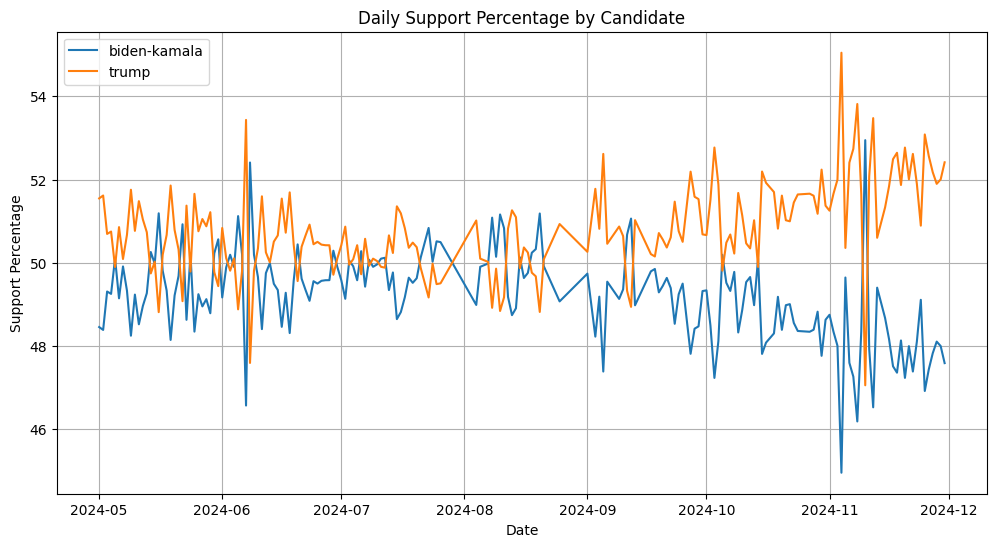

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for candidate in support_percentage_df.columns:
    plt.plot(support_percentage_df.index, support_percentage_df[candidate], label=candidate)

plt.xlabel("Date")
plt.ylabel("Support Percentage")
plt.title("Daily Support Percentage by Candidate")
plt.legend()
plt.grid(True)
plt.show()

# Approach 2 - Absolute support

In [ ]:
import pandas as pd

prediction_df1 = pd.read_csv(dir + 'election_data/election_prediction_data_2.csv')
prediction_df1.dropna(inplace=True)
print(prediction_df1.head())
print(prediction_df1)

          epoch                                       text_cleaned  prediction
0  1.714602e+09  trump rolls out the red carpet for foreign lea...           0
1  1.714604e+09  donald trump takes biggest lead ever over joe ...           1
2  1.714602e+09  phonylyinglibs obriedave1 debrasc69769469 retu...           1
3  1.714600e+09     democrats bags  biden and gullible supporters            1
4  1.714595e+09  whitneychanell almasuono not sure what there i...           2
                epoch                                       text_cleaned  \
0        1.714602e+09  trump rolls out the red carpet for foreign lea...   
1        1.714604e+09  donald trump takes biggest lead ever over joe ...   
2        1.714602e+09  phonylyinglibs obriedave1 debrasc69769469 retu...   
3        1.714600e+09     democrats bags  biden and gullible supporters    
4        1.714595e+09  whitneychanell almasuono not sure what there i...   
...               ...                                                .

In [ ]:
prediction_df1['candidate'] = prediction_df1['text_cleaned'].apply(detect_candidate)
prediction_df1 = prediction_df1[prediction_df1['candidate'] != 'other'] # Should i filter this out?

print(prediction_df1.head())
print(prediction_df1)

          epoch                                       text_cleaned  \
0  1.714602e+09  trump rolls out the red carpet for foreign lea...   
1  1.714604e+09  donald trump takes biggest lead ever over joe ...   
2  1.714602e+09  phonylyinglibs obriedave1 debrasc69769469 retu...   
3  1.714600e+09     democrats bags  biden and gullible supporters    
5  1.714599e+09  president bidens nightmare scenario just happe...   

   prediction     candidate  
0           0         trump  
1           1         trump  
2           1  biden-kamala  
3           1  biden-kamala  
5           1  biden-kamala  
                epoch                                       text_cleaned  \
0        1.714602e+09  trump rolls out the red carpet for foreign lea...   
1        1.714604e+09  donald trump takes biggest lead ever over joe ...   
2        1.714602e+09  phonylyinglibs obriedave1 debrasc69769469 retu...   
3        1.714600e+09     democrats bags  biden and gullible supporters    
5        1.714599e+

In [ ]:
prediction_df1['datetime'] = pd.to_datetime(prediction_df1['epoch'], unit='s')
prediction_df1.sort_values('datetime', inplace=True)
prediction_df1['date'] = prediction_df1['datetime'].dt.date
print(prediction_df1.head())

             epoch                                       text_cleaned  \
7269  1.714522e+09  the first week of testimony at donald trumps h...   
7246  1.714522e+09  former speaker of the house speakermccarthy jo...   
6551  1.714522e+09  biden civil rights chief to speak at columbia ...   
2878  1.714522e+09  attorneys general sue biden administration ove...   
746   1.714522e+09  meme generated by opossumal opsmcrypto \nopsm ...   

      prediction     candidate            datetime        date  
7269           0         trump 2024-05-01 00:00:00  2024-05-01  
7246           1         trump 2024-05-01 00:00:01  2024-05-01  
6551           1  biden-kamala 2024-05-01 00:00:13  2024-05-01  
2878           1  biden-kamala 2024-05-01 00:00:35  2024-05-01  
746            1         trump 2024-05-01 00:00:43  2024-05-01  


In [ ]:
# Filter out dates that has too little tweets
daily_counts = prediction_df.groupby('date').size()
threshold = 1000
valid_dates = daily_counts[daily_counts >= threshold].index

In [ ]:
prediction_counts_df = prediction_df1.groupby(['candidate', 'date'])['prediction'].value_counts().unstack(fill_value=0)

print(prediction_counts_df.head())

prediction                  0     1     2
candidate    date                        
biden-kamala 2024-05-01  1196  2983  1607
             2024-05-02  1184  2865  1562
             2024-05-03  1269  2864  1730
             2024-05-04   826  1874  1025
             2024-05-05   708  1774   949


In [ ]:
print(prediction_counts_df.columns)

Index([0, 1, 2], dtype='int64', name='prediction')


In [ ]:
# Find total tweets for candidate on a given day
prediction_counts_df['total'] = prediction_counts_df[[0, 1, 2]].sum(axis=1)

# Weighted support score calculation (negative tweets contribute 0)
prediction_counts_df['support'] = prediction_counts_df[2] * 1 + prediction_counts_df[1] * 0.5

print(prediction_counts_df.head())

prediction                  0     1     2  total  support
candidate    date                                        
biden-kamala 2024-05-01  1196  2983  1607   5786   3098.5
             2024-05-02  1184  2865  1562   5611   2994.5
             2024-05-03  1269  2864  1730   5863   3162.0
             2024-05-04   826  1874  1025   3725   1962.0
             2024-05-05   708  1774   949   3431   1836.0


In [ ]:
prediction_counts_df['support_percentage'] = (prediction_counts_df['support'] / prediction_counts_df['total']) * 100
print(prediction_counts_df[['support_percentage']].head())

prediction               support_percentage
candidate    date                          
biden-kamala 2024-05-01           53.551676
             2024-05-02           53.368384
             2024-05-03           53.931434
             2024-05-04           52.671141
             2024-05-05           53.512096


In [ ]:
prediction_counts_df = prediction_counts_df['support_percentage'].unstack(level='candidate')
print(prediction_counts_df.head())

candidate   biden-kamala      trump
date                               
2024-05-01     53.551676  56.969876
2024-05-02     53.368384  56.931887
2024-05-03     53.931434  55.445860
2024-05-04     52.671141  54.272727
2024-05-05     53.512096  53.292181


In [ ]:
# Filter out the days with less than 150 count
prediction_counts_df = prediction_counts_df.loc[valid_dates]
print(prediction_counts_df)

candidate   biden-kamala      trump
date                               
2024-05-01     53.551676  56.969876
2024-05-02     53.368384  56.931887
2024-05-03     53.931434  55.445860
2024-05-04     52.671141  54.272727
2024-05-05     53.512096  53.292181
...                  ...        ...
2024-11-26     52.414820  58.088489
2024-11-27     52.547953  57.332293
2024-11-28     56.009070  60.424448
2024-11-29     54.237640  58.762717
2024-11-30     53.162966  58.555446

[186 rows x 2 columns]


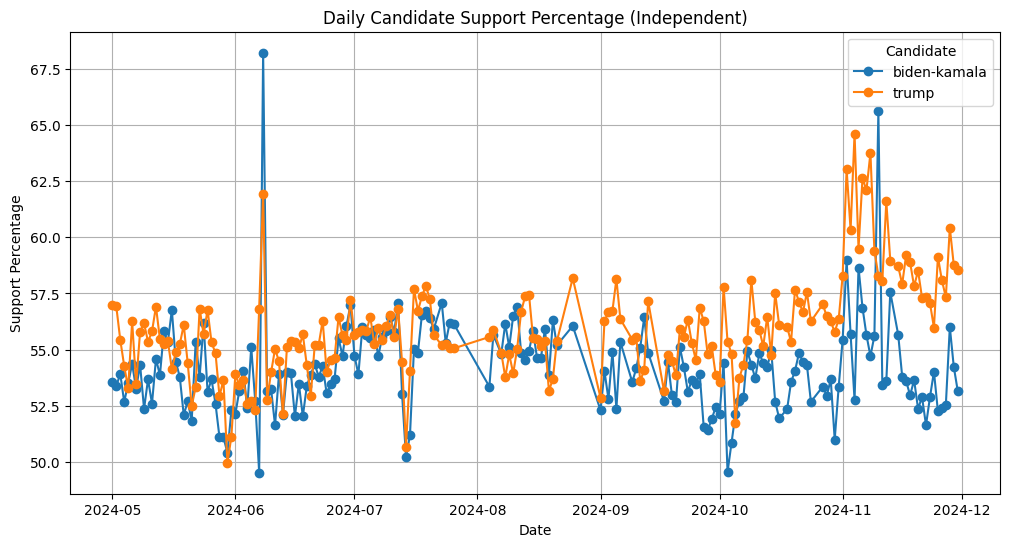

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for candidate in prediction_counts_df.columns:
    plt.plot(prediction_counts_df.index, prediction_counts_df[candidate], marker='o', label=candidate)
plt.xlabel("Date")
plt.ylabel("Support Percentage")
plt.title("Daily Candidate Support Percentage (Independent)")
plt.legend(title="Candidate")
plt.grid(True)
plt.show()